# Assignment — Network communities

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.cluster import AgglomerativeClustering
import requests
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.spatial.distance import squareform
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import datasets
from zlib import adler32

### Les Miserables graph

Let us try to detect communities in Les Miserables graph.

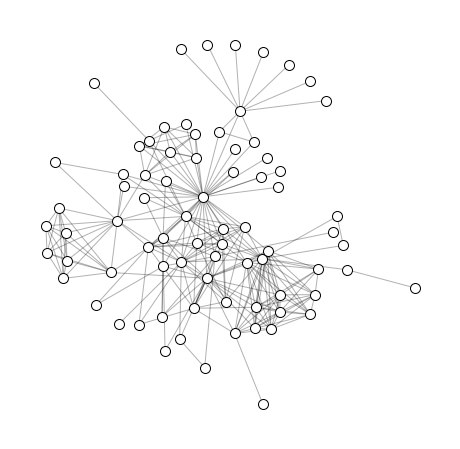

In [12]:
lesG = nx.Graph(nx.les_miserables_graph().edges)
lesG = nx.convert_node_labels_to_integers(lesG)
lespos = nx.kamada_kawai_layout(lesG)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(lesG, lespos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(lesG, lespos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. Girvan-Newman algorithm (0 points)

Let us apply Girvan-Newman algorithm with edge betweenness. The simple idea is to cut edges with highest betweenness (bridges) forming connected components.

In [13]:
def girvan_newman(G, n):
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    for division in range(n):
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(cc)] = i
    return labels

Write a function `remove_bridges` that takes a graph and remove bridges until a connected component appears.

*Hint: use `nx.edge_betweenness` to calculate edge betweenness.*

In [14]:
def remove_bridges(G):
    n_cc = nx.number_connected_components(G)
    while n_cc == nx.number_connected_components(G):
        edge_betw = nx.edge_betweenness_centrality(G)
        G.remove_edge(*max(edge_betw, key=edge_betw.get))

In [15]:
labels = girvan_newman(lesG, 6)
assert labels.shape == (6, 77)
assert np.unique(labels[0]).shape == (2,)
assert np.unique(labels[0]).shape[0] < np.unique(labels[1]).shape[0] < np.unique(labels[5]).shape[0]
assert labels[5][22] == labels[5][23]
assert labels[5][31] == labels[5][34]

Let us draw Girvan Newman algorithm step-by-step.

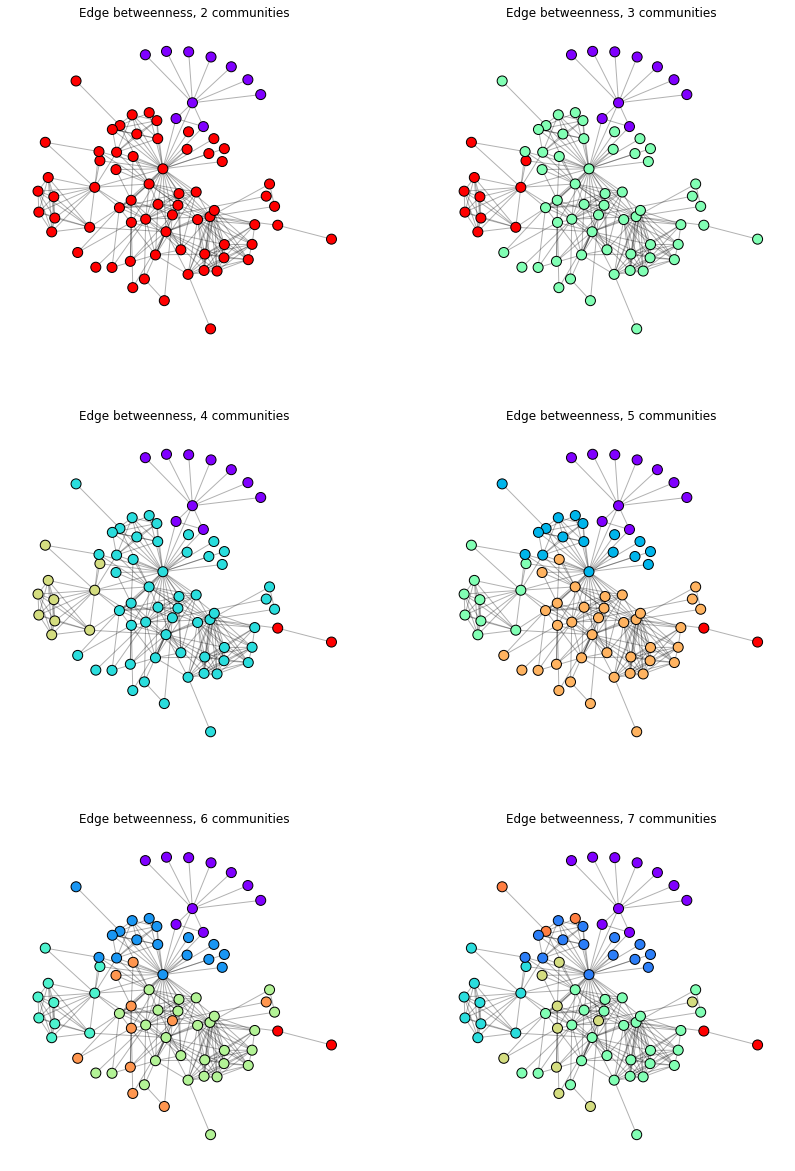

In [16]:
plt.figure(figsize=(7*2, 7*3))
for i in range(labels.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        lesG, 
        lespos,
        cmap=plt.cm.rainbow,
        node_color=labels[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(lesG, lespos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

### Task 2. Modularity (0 points)

One of the best-known methods for community detection is called modularity. 

$$M = \frac{1}{2m}\sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m} \right) \delta(c_i, c_j)$$

where $m$ is the number of edges and $\delta(c_i, c_j)$ is Kronecker delta, it is equal 1 if nodes belong to the same community and 0 otherwise. Modularity is based on expected number of edges between nodes in Configuration model


$$\frac{k_ik_j}{2m-1} \approx \frac{k_ik_j}{2m}$$

<img src='http://networksciencebook.com/images/ch-04/figure-4-15.jpg' width=400>

Indeed, $k_i$ stubs can be connected to $k_j$ stubs between nodes $i$ and $j$ and there are $2m - 1$ ways to connect a stub for any other stub that can be approximated by $2m$ in a large network. That is, modularity measures the difference between expected number of edges and actual number of edges between nodes — the large modularity, the better partitioning. Let us implement modularity calculation.

`modularity` function takes an adjacency matrix and list of lists of nodes that belong to the same community and returns modularity score.

In [17]:
def modularity(A, communities):
    m = A.sum() / 2
    res = (A - expected_edges(A, m)) * kronecker(A, communities)
    return res.sum() / 2 / m

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [18]:
def expected_edges(A, m):
    return A.sum(axis=1, keepdims=True) * A.sum(axis=0, keepdims=True) / 2 / m

In [19]:
A = nx.to_numpy_array(lesG)
m = lesG.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(lesG.degree[10] * lesG.degree[10] / 2 / m, 2)

Write a function `kronecked` that takes an adjacency matrix and list of lists of nodes that belong to the same community and returns a np.array with Kronecked delta.

In [20]:
def kronecker(A, communities):
    res = np.zeros_like(A)
    for comm in communities:
      for i in comm:
        for j in comm:
          res[i, j] = 1
    return res

In [21]:
A = nx.to_numpy_array(lesG)
communities = [np.arange(0, 10), np.arange(10, len(lesG))]
kd = kronecker(A, communities)
assert kd.shape == A.shape
assert kd[0, 9] == 1 and kd[10, 11] == 1
assert kd[0, 10] == 0

Write a function `edge_betw_modularity` that takes a graph, number of iterations of Girvan Newman algorithm and returns a np.array with modularity after each iteration.

In [22]:
def edge_betw_modularity(G, n):
    res = []
    A = nx.to_numpy_array(G)
    com_gen = nx.community.girvan_newman(G)
    for i in range(n):
      communities = next(com_gen)
      res.append(modularity(A, communities))
    return np.array(res)

In [23]:
n_iterations = 20
mod_val = edge_betw_modularity(lesG, n_iterations)
assert mod_val.shape == (n_iterations, )
assert round(mod_val[0], 4) == 0.0746
assert round(mod_val[7], 4) == 0.4519

Let us draw dependency between a number of iteration and modularity.

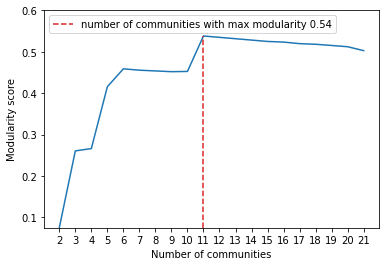

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, mod_val)
best_n = np.argmax(mod_val) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(mod_val))
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)], 
    linestyle='--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.xticks(np.arange(n_iterations)+2)
plt.ylim((mod_val.min(), 0.6))
plt.show()

### Task 3. Louvain method (4 points)

Louvain method is one of the mostcited works in the community detection literature. It is a heuristic method based on modularity optimization for extracting the community structure of large networks. Let us consider this method on a ring of cliques.

In [25]:
def ring_of_cliques(csize, n):
    cliques = []
    for _ in range(n):
        cliques.append(nx.complete_graph(csize))
    G = nx.disjoint_union_all(cliques)
    for i in range(n):
        node_i = i * csize
        node_j = ((i + 1) * csize + 1) % (csize * n)
        G.add_edge(node_i, node_j)
    return G

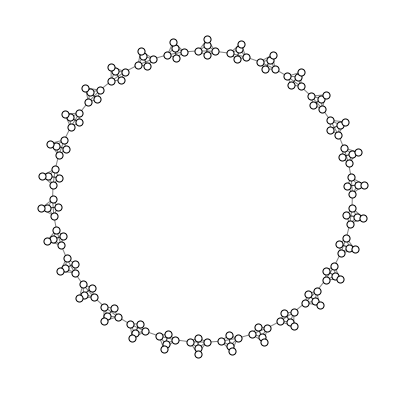

In [26]:
ringG = ring_of_cliques(csize=5, n=30)

plt.figure(figsize=(7, 7))
pos = nx.kamada_kawai_layout(ringG)
nx.draw_networkx_nodes(ringG, pos, node_color='white', 
                       edgecolors='black', node_size=50)
nx.draw_networkx_edges(ringG, pos, alpha=0.5)
plt.axis('off')
plt.show()

Let us compute expected number of edges for modularity calculation
$$e_{ij} = \frac{k_ik_j}{2m}$$
where $k_i$ is a degree of the node i and $m$ is the number of edges in a graph.

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [27]:
def expected_edges(A, m):
    # YOUR CODE HERE
    return A.sum(axis=1, keepdims=True) * A.sum(axis=0, keepdims=True) / 2 / m

In [28]:
A = nx.to_numpy_array(ringG)
m = ringG.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(ringG.degree[10] * ringG.degree[10] / 2 / m, 2)

Modularity helps to select a community that a node should belong to. Note that calculating the modularity costs $O(n^2)$, instead we can calculate *modularity gain* for $O(n)$. Consider community $c_\text{old}$ with a node $i$ and a community $c_\text{new}$ without a node $i$. The modularity gain is the change of modularity if we move a node $i$ from community $c_\text{old}$ into community $c_\text{new}$

$$\Delta M_i = \frac{1}{m}\left[ \sum_{j\in c_\text{new}} \left( A_{ij} - e_{ij} \right) - \sum_{j\in c_\text{old} \setminus \{i\}} \left( A_{ij} - e_{ij} \right) \right] $$

Write a function `modularity_gain` that takes an adjacency matrix `A`, expected edges `ee`, a moving node `mnode`, initial community `old_comm`, new community `new_comm` and number of edges `m`. It returns modularity gain. For simplicity, assume initial community does not contain a moving node.

In [29]:
def modularity_gain(A, ee, mnode, old_comm, new_comm, m):
    # YOUR CODE HERE
    return ((A - ee)[mnode, new_comm].sum() - (A - ee)[mnode, old_comm].sum()) / m

In [30]:
G = nx.complete_graph(6)
m1 = nx.algorithms.community.modularity(G, [[0, 1, 2], [3, 4, 5]])
m2 = nx.algorithms.community.modularity(G, [[0, 1], [2, 3, 4, 5]])
nx_gain = m2 - m1
nx_mod = nx.algorithms.community.modularity
del nx.algorithms.community.modularity
try:
    A = nx.to_numpy_array(G)
    m = G.number_of_edges()
    ee = expected_edges(A, m)
    gain = modularity_gain(A, ee, 2, [0, 1], [3, 4, 5], m)
except:
    raise AssertionError('networkx modularity usage')
finally:
    nx.algorithms.community.modularity = nx_mod
    del nx_mod
assert np.isclose(nx_gain, gain)

Louvain method

Phase 1: community unfolding
1. Put each node in its own community
2. For every node, calculate modularity gain and move it to the community with maximal modularity gain
3. Repeat until modularity stops increasing

Phase 2: network aggregation
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [31]:
def louvain_method(G):
    
    # Phase 1: community unfolding
    communities = unfolded_communities(G)

    # Create labels
    labels = np.zeros(len(G))
    for i, c in enumerate(communities):
        labels[c] = i
    
    # Phase 2: network aggregation
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        nextG.add_edge(labels[int(e[0])], labels[int(e[1])])
       
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns list of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [36]:
def unfolded_communities(G):
    # Proposed template:
    A = nx.to_numpy_array(G)
    m = A.sum() / 2
    ee = expected_edges(A, m)
    communities = [[n] for n in G.nodes] # initial partition
    max_modularity_gain = 1
    while max_modularity_gain > 0:
        for node in G.nodes:
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and put a node 
               in the community with maximal modularity gain. If 
               there is no modularity gain, return the node into 
               the initial community.
            '''
            # YOUR CODE HERE
            initial_comm = None
            for comm in communities:
              if node in comm:
                comm.remove(node)
                initial_comm = comm
            
            best_comm = None
            for comm in communities:
              if len(set(comm) & set(nx.neighbors(G, node))):
                comm.append(node)
                cur_mod = nx.algorithms.community.modularity(G, communities)
                comm.remove(node)
                if cur_mod > max_modularity_gain:
                  max_modularity_gain = cur_mod
                  best_comm = comm
            if best_comm is not None:
              best_comm.append(node)
            else:
              initial_comm.append(node)
    return [c for c in communities if len(c)]

In [ ]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
communities, labels, iterG = louvain_method(iterG)
assert len(set(labels)) == 30
assert len(set(labels[0:5])) == 1
assert len(set(labels[5:15])) == 2
assert iterG.number_of_nodes() == 30
for _ in range(2):
    communities, labels, iterG = louvain_method(iterG)
assert round(nx.algorithms.community.modularity(iterG, communities), 3) == 0.888

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

In [ ]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
plt.figure(figsize=(7, 8*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    # Shuffle label names for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    iter_pos = nx.kamada_kawai_layout(iterG)
    degree = np.array([d for n, d in iterG.degree])
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=10*degree
    )
    _iterG = iterG.copy()
    _iterG.remove_edges_from(nx.selfloop_edges(iterG))
    nx.draw_networkx_edges(_iterG, iter_pos, alpha=0.5)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.3f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

Communities in Les Miserables graph

In [ ]:
iterG = lesG.copy()
prev_comm, labels, iterG = louvain_method(iterG)
for i in range(2):
    next_comm, labels, iterG = louvain_method(iterG)
    communities = []
    for c in next_comm:
        temp = []
        for node in c:
            temp.extend(prev_comm[node])
        communities.append(temp)
    prev_comm = communities.copy()
labels = np.zeros(len(lesG))
for i, c in enumerate(communities):
    labels[c] = i

In [ ]:
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    lesG, 
    lespos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(lesG, lespos, alpha=0.3)
plt.title(
    '{} communities\nModularity {:.3f}'.format(
        len(communities), 
        nx.community.modularity(lesG, communities)
    )
)
plt.axis('off');

### Task 4. Label propagation for clustering (3 points)

Among all the community detection techniques, label propagation is neither the most accurate nor the most robust method. It is, however, without doubt one of the simplest and fastest clustering methods. The label propagation method is based on the simple idea: every node is initialized with a unique label and at every step each node adopts the label that most of its neighbors currently have.

Write a function `update_labels` that takes a graph, np.array with labels in order `graph.nodes` and returns new labels. Label of the node is the random label occurring with the highest frequency among neighbors. At every iteration of label propagation, all nodes update their labels simultaneously (synchronous propagation).

In [35]:
def sync_update_labels(graph, labels):
    # YOUR CODE HERE
    dict_node_label = {node: labels[node] for node in graph.nodes}
    new_labels = {}
    for node in graph.nodes:
        temp_label = []
        for neighbour in list(nx.neighbors(graph, node)):
                temp_label.append(dict_node_label[neighbour])
        
        dict_iter = {}
        for idx in temp_label:
            if idx not in dict_iter:
                dict_iter[idx] = 1
            else:
                dict_iter[idx] += 1
        max_iter = max(dict_iter.values())
        my_label = []
        for a, b in dict_iter.items():
            if b == max_iter:
                my_label.append(a)

        new_labels[node] = np.random.choice(my_label)
    return np.array(list(new_labels.values()))

In [36]:
nodes = set()
for _ in range(100):
    triadeG = nx.Graph([(0, 1), (0, 2)])
    labels = np.array(list(triadeG.nodes))
    labels = sync_update_labels(triadeG, labels)
    nodes = nodes.union(labels)
assert set([0, 1, 2]) == nodes # check randomness
labels = np.array(list(lesG.nodes)) # initial partition
new_labels = sync_update_labels(lesG, labels)
assert new_labels.shape == (77, )
assert len(set(new_labels)) < len(set(labels))
for _ in range(30):
    new_labels = sync_update_labels(lesG, new_labels)
assert len(set(new_labels)) > 1
starG = nx.star_graph(4)
labels = np.array(list(starG.nodes)) # initial partition
for _ in range(5):
    labels = sync_update_labels(starG, labels)
new_labels = sync_update_labels(starG, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [37]:
def plot_propagation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(8, 8))
        nx.draw_networkx_nodes(
            G, 
            pos=pos, 
            node_color=labels, 
            cmap=plt.cm.rainbow,
            node_size=100, 
            edgecolors='black'
        )
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

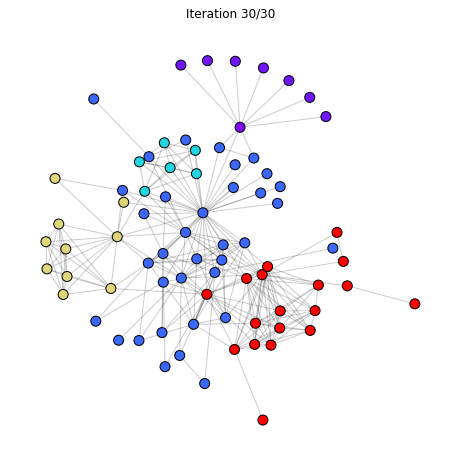

In [38]:
plot_propagation(lesG, sync_update_labels, 30)

Notice that synchronous propagation can lead to oscillations of some labels in the network that are bi-partite or nearly bi-partite in structure. This is especially true in cases where communities take the form of a star graph.

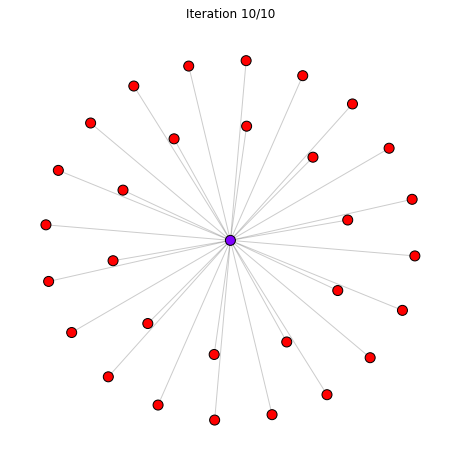

In [39]:
plot_propagation(nx.star_graph(30), sync_update_labels, 10)

For this reason, most label propagation algorithms implement asynchronous propagation. At every iteration of label propagation, the labels of the nodes are no longer updated all together, but sequentially in some random order, which is different for each iteration. This is in contrast to synchronous propagation, which always considers the labels from the previous iteration. Due to random order of label updates, asynchronous propagation successfully breaks the cyclic oscillations of labels.

Write a function `async_update_labels` that makes asynchronous label updating. The order in which all the n nodes in the network are updated is chosen randomly at each iteration.

In [40]:
def async_update_labels(graph, labels):
    # YOUR CODE HERE
    dict_node_label = {node: labels[node] for node in graph.nodes}
    new_labels = {}
    for node in np.random.permutation(graph.nodes):
        temp_label = []
        for neighbour in list(nx.neighbors(graph, node)):
                temp_label.append(dict_node_label[neighbour])
        
        dict_iter = {}
        for idx in temp_label:
            if idx not in dict_iter:
                dict_iter[idx] = 1
            else:
                dict_iter[idx] += 1
        max_iter = max(dict_iter.values())
        my_label = []
        for a, b in dict_iter.items():
            if b == max_iter:
                my_label.append(a)

        new_labels[node] = np.random.choice(my_label)
    return np.array(list(new_labels.values()))

In [41]:
labels = np.array(list(lesG.nodes)) # initial partition
new_labels = async_update_labels(lesG, labels)
assert new_labels.shape == (77, )
assert len(set(new_labels)) < len(set(labels))
labels = np.array(list(starG.nodes)) # initial partition
for _ in range(5):
    labels = async_update_labels(starG, labels)
new_labels = async_update_labels(starG, labels)
assert np.all(new_labels - labels == 0)

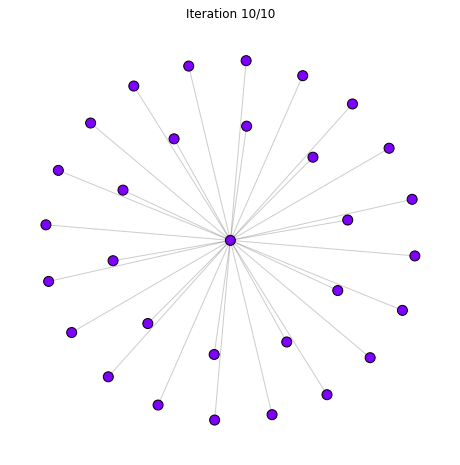

In [42]:
plot_propagation(nx.star_graph(30), async_update_labels, 10)

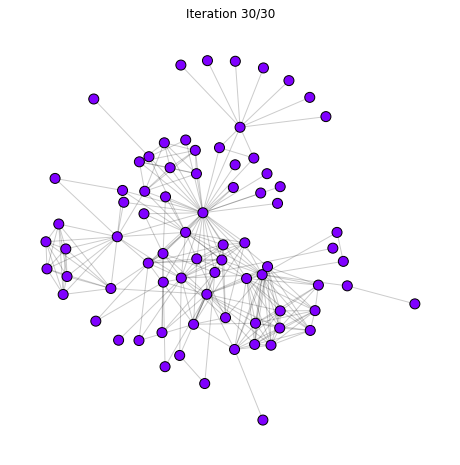

In [43]:
plot_propagation(lesG, async_update_labels, 30)

### Task 5. Ego-splitting (3 points)

Ego-Splitting is a framework for detecting clusters in complex networks which leverage the local structures known as ego-nets (i.e. the subgraph induced by the neighborhood of each node) to detect overlapping clusters. Ego-splittng is a highly scalable and flexible framework, with provable theoretical guarantees, that reduces the complex overlapping clustering problem to a simpler and more amenable non-overlapping (partitioning) problem.

Let us consider the algorithm on this small graph.

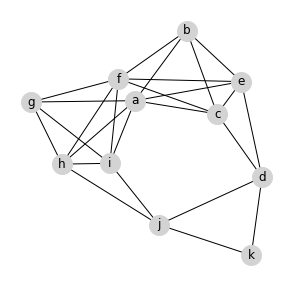

In [44]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j',
    'h j',
    'j d k',
    'd k'
]
G = nx.parse_adjlist(adjlist)
plt.figure(figsize=(5, 5))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(
    G, pos, node_size=400, node_color='lightgray')
plt.axis('off');

The ego-splitting algorithm processes a graph and outputs a set of clusters as follows:
1. For each node we use the local clustering algorithm to partition the ego-net of the node.
2. Create a persona graph. Each node in the graph will correspond to $n$ "personas" (nodes in persona graph) where $n$ is a number of clusters in node's ego-net.
3. Apply the global clustering algorithm.

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/ego_splitting.png)

In [45]:
def ego_splitting(graph):
    ego_nets = generate_ego_nets(graph)
    persona_graph = generate_persona_graph(ego_nets)
    return persona_clustering(personaG)

Write a function `generate_ego_nets` that takes a graph and returns a dictionary where keys are nodes and values are their ego-nets:

`{'a': ego-net of the node a, 'b': ego-net of the node b, ...}`

Ego-net *does not* include the ego-node.

*Hint: use `nx.ego_graph`*

In [46]:
def generate_ego_nets(graph):
    # YOUR CODE HERE
    result = {}
    for node in graph:
      result[node] = nx.ego_graph(graph, node, center=False)
    return result

In [47]:
ego_nets = generate_ego_nets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

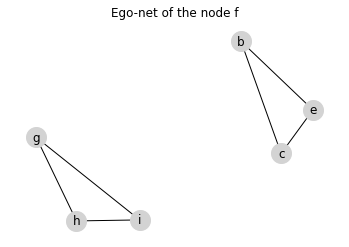

In [48]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G), 
        node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Next, we need to split each ego-net using any clustering method. Let it be the simple connected component detection method. 

In [49]:
def ego_clustering(graph):
    return [cc for cc in nx.connected_components(graph)]

Write a function `generate_persona_graph` that takes an ego-net dictionary and returns a persona graph:
1. Add a persona into each cluster in an ego-net and link it to each member. If there is more than one cluster then the persona name is the node name + cluster index. For example, if the ego-net `a` has two clusters `[b, c]` and `[d]` then we add peronas `a0, a1` and links `[a0, b]`, `[a0, c]`, `[a1, d]`.
2. Union all ego-nets into persona graph. 
3. Remove extra initial nodes that have personas. For example, if the persona graph has nodes `a`, `a0`, `a1`, then remove the node `a`.

In [56]:
def generate_persona_graph(ego_nets):
    # YOUR CODE HERE
    replicas = set()
    personaG = nx.Graph()
    for node, net in ego_nets.items():
       
      comms = ego_clustering(net)
      if len(comms) == 1:

        for m in comms[0]:
          net.add_edge(node, m)
      elif len(comms) > 1:
        replicas.add(node)
        for idx, comm in enumerate(comms):
          for m in comm:
            net.add_edge(node + str(idx), m)
      personaG.add_edges_from(net.edges)
    personaG.remove_nodes_from(replicas)
    return personaG

In [57]:
ego_nets = generate_ego_nets(G)
personaG = generate_persona_graph(ego_nets)
assert set(personaG.nodes) == {'i', 'f0', 'k', 'c', 'd0', 'a0', 'g', 'j0', 'e', 'h', 'd1', 'a1', 'j1', 'f1', 'b'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

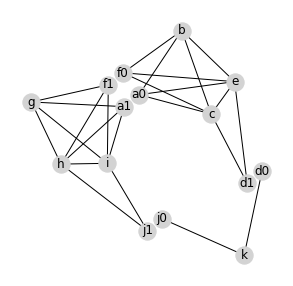

In [58]:
pos = nx.kamada_kawai_layout(G)
personapos = {}
for node in personaG.nodes:
    personapos[node] = pos[node[0]].copy()
    if len(node) > 1:
        personapos[node][0] += 0.05 if node[1] == '0' else -0.05
        personapos[node][1] += 0.05 if node[1] == '0' else -0.05
plt.figure(figsize=(5, 5))
nx.draw_networkx(personaG, personapos, node_size=300, node_color='lightgray')
plt.axis('off');

Finally, we need to apply any clustering algorithm for the persona graph. Let it again be the simple connected component detection algorithm. Also, here we remove the cluster indexes from node names.

In [59]:
def persona_clustering(graph):
    communities = []
    for cc in nx.connected_components(graph):
        communities.append([node[0] for node in cc])
    return communities

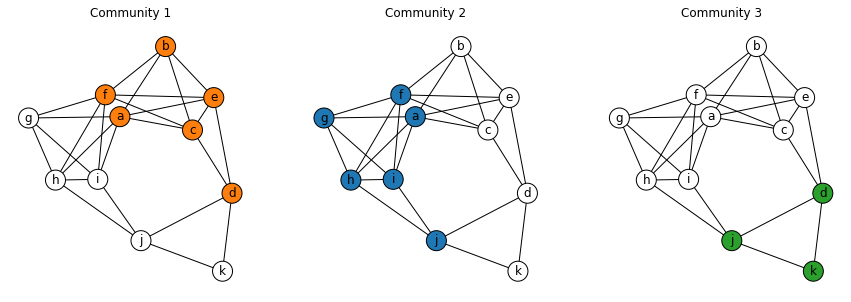

In [60]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(ego_splitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color, 
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Community {}'.format(i+1))